In [1]:
# Import libraries
import os
import geopandas as gpd
import xarray as xr
import rioxarray

In [2]:
# Data directory
data_dir = 'C:/Users/Holger/EGU2021/SC5.8/data'

In [3]:
# Import shapefile of the Baltics
shp_fp = os.path.join(data_dir, 'baltics.shp')
baltics = gpd.read_file(shp_fp)
display(baltics.crs)
display(baltics.head())

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,CNTR_ID,CNTR_NAME,NAME_ENGL,ISO3_CODE,FID,geometry
0,EE,Eesti,Estonia,EST,EE,"MULTIPOLYGON (((28.04191 59.47012, 28.04319 59..."
1,LT,Lietuva,Lithuania,LTU,LT,"MULTIPOLYGON (((26.63037 55.68067, 26.63108 55..."
2,LV,Latvija,Latvia,LVA,LV,"MULTIPOLYGON (((27.35158 57.51824, 27.36511 57..."


<AxesSubplot:>

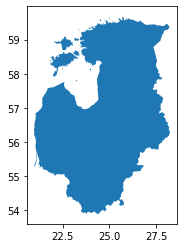

In [4]:
# Create clip polygon by dissolving the countries
baltics['dissolve'] = 'yes'
clip_polygon = baltics.dissolve(by='dissolve')
clip_polygon.plot()

In [5]:
# Open precipitation dataset and assign CRS
precip_fp = os.path.join(data_dir, 'rr_ens_mean_0.1deg_reg_v23.0e.nc')
with xr.open_dataset(precip_fp) as precip_ds:
    precip_ds.rio.write_crs('epsg:4326', inplace=True)
display(precip_ds.attrs)
display(precip_ds.var)

{'history': 'Thu Mar 18 12:28:18 2021: ncks --no-abc -d time,0,25932 /data2/Else/EOBSv23.0e/Grid_0.1deg/rr//rr_ensmean_master_rectime.nc /data2/Else/EOBSv23.0e/Grid_0.1deg/rr//rr_ens_mean_0.1deg_reg_v23.0e.nc\nThu Mar 18 12:24:03 2021: ncks --no-abc --mk_rec_dmn time /data2/Else/EOBSv23.0e/Grid_0.1deg/rr//rr_ensmean_master.nc /data2/Else/EOBSv23.0e/Grid_0.1deg/rr//rr_ensmean_master_rectime.nc',
 'NCO': 'netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)',
 'grid_mapping': 'spatial_ref'}

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:      (latitude: 465, longitude: 705, time: 25933)
Coordinates:
  * longitude    (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude     (latitude) float64 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * time         (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
    spatial_ref  int32 0
Data variables:
    rr           (time, latitude, longitude) float32 ...
Attributes:
    history:       Thu Mar 18 12:28:18 2021: ncks --no-abc -d time,0,25932 /d...
    NCO:           netCDF Operators version 4.7.5 (Homepage = http://nco.sf.n...
    grid_mapping:  spatial_ref>

In [6]:
# Create a list of clipped data slices with monthly precipitation sum
precip_datasets = []
for year in range(2001, 2021):
    ds = precip_ds.sel(time=str(year))
    ds = ds.rio.clip(clip_polygon.geometry, clip_polygon.crs)
    monthly_ds = ds.resample(time='1m').sum(skipna=False)
    precip_datasets.append(monthly_ds)

In [7]:
# Concat the monthly datasets
monthly_precip_ds = xr.concat(precip_datasets, dim='time')
monthly_precip_ds

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, time: 240)
Coordinates:
  * time         (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2020-12-31
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
    spatial_ref  int32 0
Data variables:
    rr           (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [8]:
# Convert the xarray to Pandas dataframe
precip_df = monthly_precip_ds.to_dataframe().reset_index()
precip_df

,latitude,longitude,time,spatial_ref,rr
0,53.949860,21.04986,2001-01-31,0,NaN
1,53.949860,21.04986,2001-02-28,0,NaN
2,53.949860,21.04986,2001-03-31,0,NaN
3,53.949860,21.04986,2001-04-30,0,NaN
4,53.949860,21.04986,2001-05-31,0,NaN
...,...,...,...,...,...
984955,59.549859,28.14986,2020-08-31,0,NaN
984956,59.549859,28.14986,2020-09-30,0,NaN
984957,59.549859,28.14986,2020-10-31,0,NaN
984958,59.549859,28.14986,2020-11-30,0,NaN


In [9]:
precip_df['ym'] = precip_df['time'].dt.strftime('%Y-%m')
precip_df.rename(columns={'rr': 'precip_sum'}, inplace=True)
precip_df.drop(columns=['time', 'spatial_ref'], inplace=True)
precip_df

,latitude,longitude,precip_sum,ym
0,53.949860,21.04986,NaN,2001-01
1,53.949860,21.04986,NaN,2001-02
2,53.949860,21.04986,NaN,2001-03
3,53.949860,21.04986,NaN,2001-04
4,53.949860,21.04986,NaN,2001-05
...,...,...,...,...
984955,59.549859,28.14986,NaN,2020-08
984956,59.549859,28.14986,NaN,2020-09
984957,59.549859,28.14986,NaN,2020-10
984958,59.549859,28.14986,NaN,2020-11


In [10]:
# Convert the DataFrame back to xarray Dataset
df = precip_df.copy()
df.set_index(['latitude', 'longitude', 'ym'], inplace=True)
precip_array = df.to_xarray()
precip_array

<xarray.Dataset>
Dimensions:     (latitude: 57, longitude: 72, ym: 240)
Coordinates:
  * latitude    (latitude) float64 53.95 54.05 54.15 54.25 ... 59.35 59.45 59.55
  * longitude   (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * ym          (ym) object '2001-01' '2001-02' ... '2020-11' '2020-12'
Data variables:
    precip_sum  (latitude, longitude, ym) float32 nan nan nan ... nan nan nan

In [11]:
precip_array.rio.write_crs('epsg:4326', inplace=True)

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, ym: 240)
Coordinates:
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * ym           (ym) object '2001-01' '2001-02' ... '2020-11' '2020-12'
    spatial_ref  int32 0
Data variables:
    precip_sum   (latitude, longitude, ym) float32 nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [12]:
# Write precipitation data into NetCDF
precip_array.to_netcdf(os.path.join(data_dir, 'monthly_precip_baltics.nc'))

In [13]:
# Open temperature dataset and assign CRS
temp_fp = os.path.join(data_dir, 'tg_ens_mean_0.1deg_reg_v23.0e.nc')
with xr.open_dataset(temp_fp) as temp_ds:
    temp_ds.rio.write_crs('epsg:4326', inplace=True)
display(temp_ds.attrs)
display(temp_ds.var)

{'E-OBS_version': '23.0e',
 'Conventions': 'CF-1.4',
 'References': 'http://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php',
 'history': 'Tue Mar 16 13:02:20 2021: ncks --no-abc -d time,0,25932 /data2/Else/EOBSv23.0e/Grid_0.1deg/tg//tg_ensmean_master_rectime.nc /data2/Else/EOBSv23.0e/Grid_0.1deg/tg//tg_ens_mean_0.1deg_reg_v23.0e.nc\nTue Mar 16 12:54:03 2021: ncks --no-abc --mk_rec_dmn time /data2/Else/EOBSv23.0e/Grid_0.1deg/tg//tg_ensmean_master.nc /data2/Else/EOBSv23.0e/Grid_0.1deg/tg//tg_ensmean_master_rectime.nc',
 'NCO': 'netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)',
 'grid_mapping': 'spatial_ref'}

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:      (latitude: 465, longitude: 705, time: 25933)
Coordinates:
  * longitude    (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude     (latitude) float64 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * time         (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
    spatial_ref  int32 0
Data variables:
    tg           (time, latitude, longitude) float32 ...
Attributes:
    E-OBS_version:  23.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Tue Mar 16 13:02:20 2021: ncks --no-abc -d time,0,25932 /...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....
    grid_mapping:   spatial_ref>

In [14]:
# Create a list of clipped data slices with monthly temperature mean
temp_datasets = []
for year in range(2001, 2021):
    ds = temp_ds.sel(time=str(year))
    ds = ds.rio.clip(clip_polygon.geometry, clip_polygon.crs)
    monthly_ds = ds.resample(time='1m').mean(skipna=False)
    temp_datasets.append(monthly_ds)

In [15]:
# Concat the monthly datasets
monthly_temp_ds = xr.concat(temp_datasets, dim='time')
display(monthly_temp_ds)

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, time: 240)
Coordinates:
  * time         (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2020-12-31
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
    spatial_ref  int32 0
Data variables:
    tg           (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [16]:
# Convert the xarray to Pandas dataframe
temp_df = monthly_temp_ds.to_dataframe().reset_index()
temp_df['ym'] = temp_df['time'].dt.strftime('%Y-%m')
temp_df.rename(columns={'tg': 'temp_mean'}, inplace=True)
temp_df.drop(columns=['time', 'spatial_ref'], inplace=True)
temp_df

,latitude,longitude,temp_mean,ym
0,53.949861,21.04986,NaN,2001-01
1,53.949861,21.04986,NaN,2001-02
2,53.949861,21.04986,NaN,2001-03
3,53.949861,21.04986,NaN,2001-04
4,53.949861,21.04986,NaN,2001-05
...,...,...,...,...
984955,59.549861,28.14986,NaN,2020-08
984956,59.549861,28.14986,NaN,2020-09
984957,59.549861,28.14986,NaN,2020-10
984958,59.549861,28.14986,NaN,2020-11


In [17]:
# Convert the DataFrame back to xarray Dataset
df = temp_df.copy()
df.set_index(['latitude', 'longitude', 'ym'], inplace=True)
temp_array = df.to_xarray()
temp_array

<xarray.Dataset>
Dimensions:    (latitude: 57, longitude: 72, ym: 240)
Coordinates:
  * latitude   (latitude) float64 53.95 54.05 54.15 54.25 ... 59.35 59.45 59.55
  * longitude  (longitude) float64 21.05 21.15 21.25 21.35 ... 27.95 28.05 28.15
  * ym         (ym) object '2001-01' '2001-02' '2001-03' ... '2020-11' '2020-12'
Data variables:
    temp_mean  (latitude, longitude, ym) float32 nan nan nan nan ... nan nan nan

In [18]:
temp_array.rio.write_crs('epsg:4326', inplace=True)

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, ym: 240)
Coordinates:
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * ym           (ym) object '2001-01' '2001-02' ... '2020-11' '2020-12'
    spatial_ref  int32 0
Data variables:
    temp_mean    (latitude, longitude, ym) float32 nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [19]:
# Write into NetCDF
temp_array.to_netcdf(os.path.join(data_dir, 'monthly_temp_baltics.nc'))

In [20]:
display(precip_array)
display(temp_array)

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, ym: 240)
Coordinates:
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * ym           (ym) object '2001-01' '2001-02' ... '2020-11' '2020-12'
    spatial_ref  int32 0
Data variables:
    precip_sum   (latitude, longitude, ym) float32 nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref

<xarray.Dataset>
Dimensions:      (latitude: 57, longitude: 72, ym: 240)
Coordinates:
  * latitude     (latitude) float64 53.95 54.05 54.15 ... 59.35 59.45 59.55
  * longitude    (longitude) float64 21.05 21.15 21.25 ... 27.95 28.05 28.15
  * ym           (ym) object '2001-01' '2001-02' ... '2020-11' '2020-12'
    spatial_ref  int32 0
Data variables:
    temp_mean    (latitude, longitude, ym) float32 nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  spatial_ref